In [ ]:
,
# Step 1: Install necessary libraries
!pip install pandas transformers torch scikit-learn matplotlib seaborn

# Step 2: Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Load dataset
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Step 4: Data Cleaning
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

df['headline'] = df['headline'].apply(clean_text)
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

# Step 5: Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 6: Define X and y for Logistic Regression
X_train, X_test = train_df['headline'], test_df['headline']
y_train, y_test = train_df['is_sarcastic'], test_df['is_sarcastic']



FileNotFoundError: File /content/Sarcasm_Headlines_Dataset_v2.json does not exist

In [ ]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

# Predictions and Accuracy for Logistic Regression
y_pred_lr = log_reg.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Model Accuracy: {accuracy_lr * 100:.2f}%")


Logistic Regression Model Accuracy: 82.70%


In [ ]:
# Tokenization for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=64)

# Create Dataset Class for BERT
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(train_encodings, y_train.tolist())
test_dataset = SarcasmDataset(test_encodings, y_test.tolist())

# Load and train the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# BERT Model Evaluation
outputs = trainer.predict(test_dataset)
preds_bert = np.argmax(outputs.predictions, axis=1)
accuracy_bert = accuracy_score(y_test, preds_bert)
print(f"BERT Model Accuracy: {accuracy_bert * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.146100,0.264499


BERT Model Accuracy: 91.61%


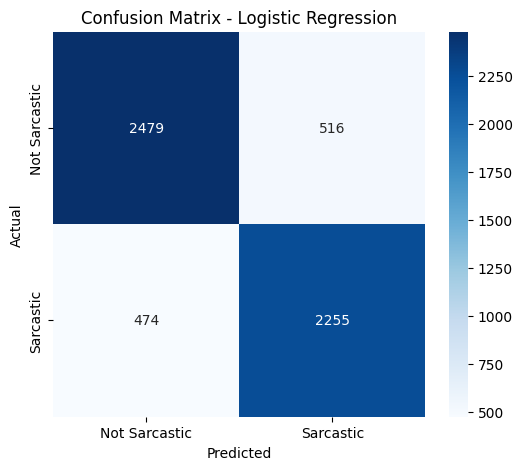

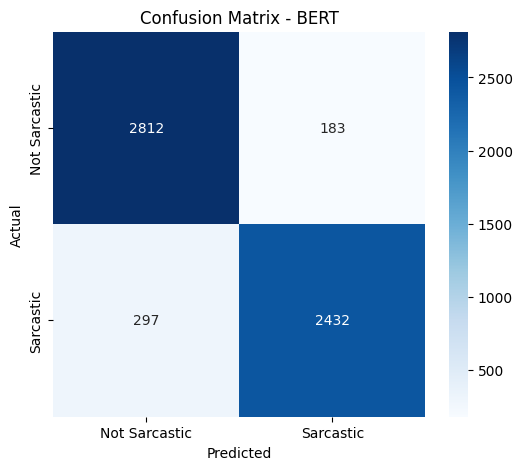

<ipython-input-7-04eaeb2582f8>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


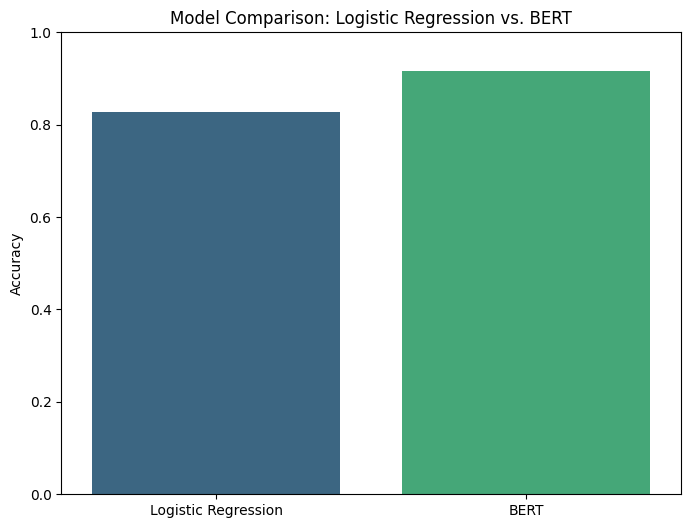

In [ ]:
# Confusion Matrix for both models
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Confusion Matrix for Logistic Regression
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

# Confusion Matrix for BERT
plot_confusion_matrix(y_test, preds_bert, "BERT")

# Bar plot comparing the accuracies
models = ['Logistic Regression', 'BERT']
accuracies = [accuracy_lr, accuracy_bert]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Model Comparison: Logistic Regression vs. BERT")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


In [ ]:
!pip install pandas transformers torch scikit-learn matplotlib seaborn


In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

# Load the dataset
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Data cleaning function
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()

df['headline'] = df['headline'].apply(clean_text)
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Prepare data for Logistic Regression
X_train, X_test = train_df['headline'], test_df['headline']
y_train, y_test = train_df['is_sarcastic'], test_df['is_sarcastic']

# Vectorization using TF-IDF for Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

# Predictions for Logistic Regression
y_pred_lr = log_reg.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")

# Tokenization for BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings_bert = bert_tokenizer(list(X_train), truncation=True, padding=True, max_length=64)
test_encodings_bert = bert_tokenizer(list(X_test), truncation=True, padding=True, max_length=64)

# Create Dataset Class for BERT
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_bert = SarcasmDataset(train_encodings_bert, y_train.tolist())
test_dataset_bert = SarcasmDataset(test_encodings_bert, y_test.tolist())

# Train BERT Model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    report_to="none"
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert
)

trainer_bert.train()

# Evaluate BERT Model
outputs_bert = trainer_bert.predict(test_dataset_bert)
preds_bert = np.argmax(outputs_bert.predictions, axis=1)
accuracy_bert = accuracy_score(y_test, preds_bert)
print(f"BERT Model Accuracy: {accuracy_bert * 100:.2f}%")

# Tokenization for RoBERTa
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings_roberta = roberta_tokenizer(list(X_train), truncation=True, padding=True, max_length=64)
test_encodings_roberta = roberta_tokenizer(list(X_test), truncation=True, padding=True, max_length=64)

# Create Dataset Class for RoBERTa
train_dataset_roberta = SarcasmDataset(train_encodings_roberta, y_train.tolist())
test_dataset_roberta = SarcasmDataset(test_encodings_roberta, y_test.tolist())

# Train RoBERTa Model
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_roberta',
    evaluation_strategy="epoch",
    report_to="none"
)

trainer_roberta = Trainer(
    model=roberta_model,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=test_dataset_roberta
)

trainer_roberta.train()

# Evaluate RoBERTa Model
outputs_roberta = trainer_roberta.predict(test_dataset_roberta)
preds_roberta = np.argmax(outputs_roberta.predictions, axis=1)
accuracy_roberta = accuracy_score(y_test, preds_roberta)
print(f"RoBERTa Model Accuracy: {accuracy_roberta * 100:.2f}%")

# Confusion Matrix function
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_test, preds_bert, "BERT")
plot_confusion_matrix(y_test, preds_roberta, "RoBERTa")

# Bar plot comparing accuracies of all three models
models = ['Logistic Regression', 'BERT', 'RoBERTa']
accuracies = [accuracy_lr, accuracy_bert, accuracy_roberta]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Model Comparison: Logistic Regression vs. BERT vs. RoBERTa")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


Logistic Regression Accuracy: 82.70%


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [ ]:
!pip uninstall torch -y


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121


In [ ]:
!pip install torch==2.1.0+cpu torchvision==0.15.2+cpu torchaudio==2.1.0


ERROR: Could not find a version that satisfies the requirement torch==2.1.0+cpu (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch==2.1.0+cpu


In [ ]:
import torch
print(torch.__version__)


ModuleNotFoundError: No module named 'torch'

In [ ]:
!pip install torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.291600,0.295876


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformer

Epoch,Training Loss,Validation Loss
1,0.293500,0.294583


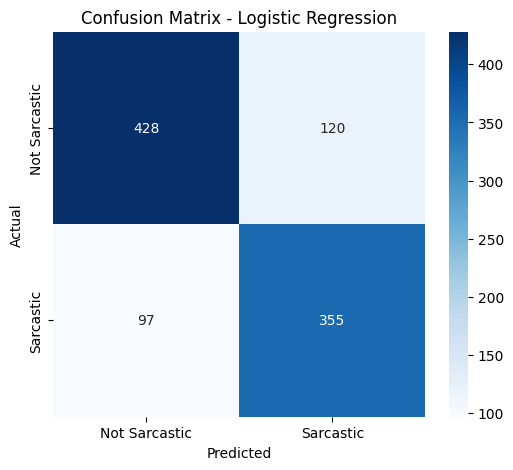

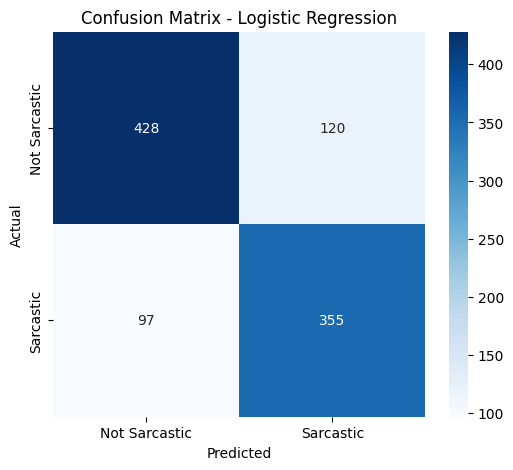

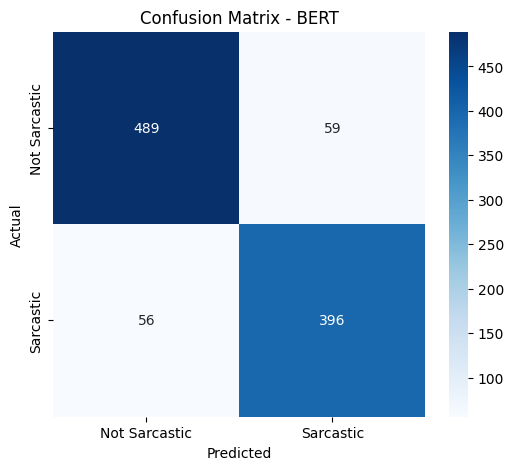

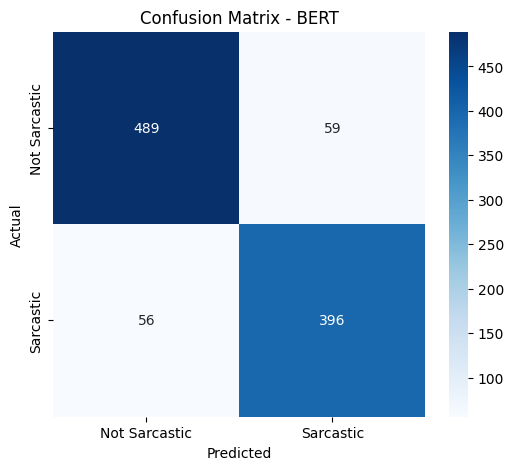

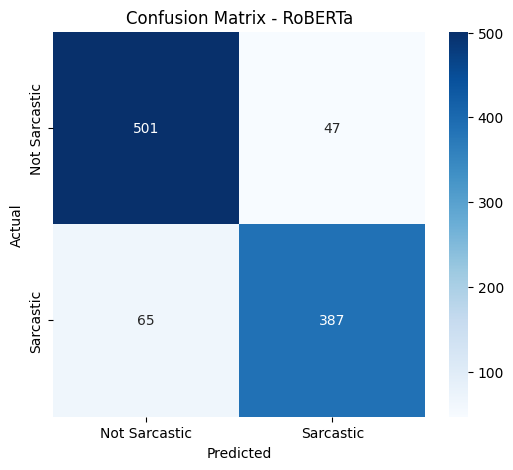

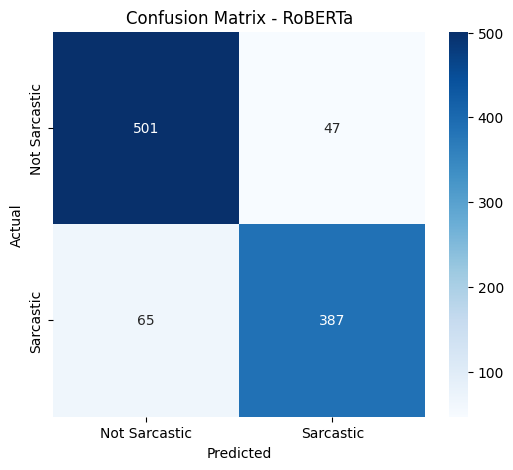

<ipython-input-1-be6593b9bc2e>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')
<ipython-input-1-be6593b9bc2e>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


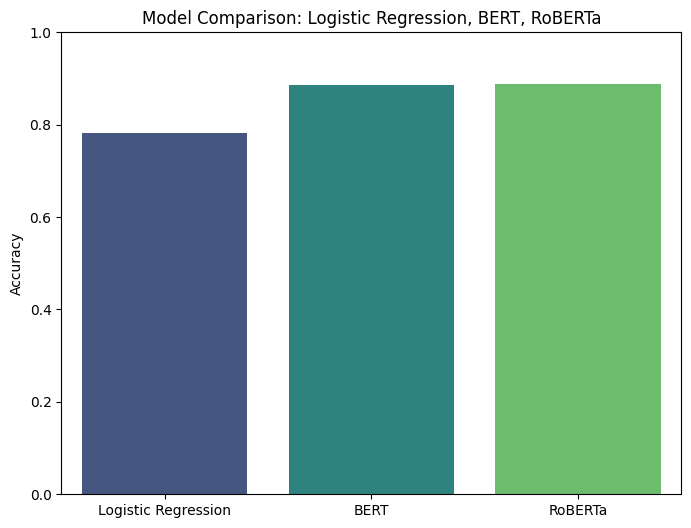

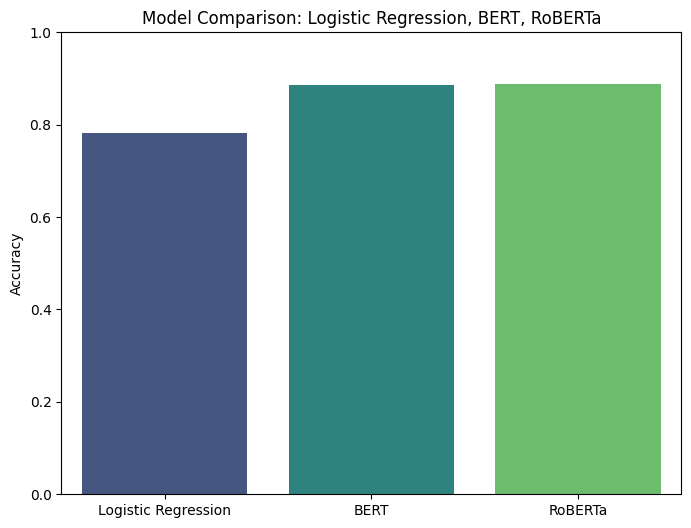

In [ ]:
# Install necessary libraries
!pip install pandas transformers torch scikit-learn matplotlib seaborn -q

# Import libraries
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Data cleaning
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text).lower()

df['headline'] = df['headline'].apply(clean_text)
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

# Subset for faster processing
df = df.sample(5000, random_state=42)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train, X_test = train_df['headline'], test_df['headline']
y_train, y_test = train_df['is_sarcastic'], test_df['is_sarcastic']

# Logistic Regression Model
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)
y_pred_lr = log_reg.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# BERT Model
def train_transformer_model(tokenizer, model_class, model_name, train_texts, train_labels, test_texts, test_labels):
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64)

    class SarcasmDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = SarcasmDataset(train_encodings, train_labels.tolist())
    test_dataset = SarcasmDataset(test_encodings, test_labels.tolist())

    model = model_class.from_pretrained(model_name, num_labels=2)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=1,
        per_device_train_batch_size=8,
        evaluation_strategy="epoch",
        logging_dir='./logs',
        logging_steps=10,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    trainer.train()
    outputs = trainer.predict(test_dataset)
    preds = np.argmax(outputs.predictions, axis=1)
    accuracy = accuracy_score(test_labels, preds)
    return accuracy, preds

# Train BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
accuracy_bert, preds_bert = train_transformer_model(
    bert_tokenizer, BertForSequenceClassification, 'bert-base-uncased', X_train, y_train, X_test, y_test
)

# Train RoBERTa
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
accuracy_roberta, preds_roberta = train_transformer_model(
    roberta_tokenizer, RobertaForSequenceClassification, 'roberta-base', X_train, y_train, X_test, y_test
)

# Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Logistic Regression Confusion Matrix
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

# BERT Confusion Matrix
plot_confusion_matrix(y_test, preds_bert, "BERT")

# RoBERTa Confusion Matrix
plot_confusion_matrix(y_test, preds_roberta, "RoBERTa")

# Accuracy Comparison
models = ['Logistic Regression', 'BERT', 'RoBERTa']
accuracies = [accuracy_lr, accuracy_bert, accuracy_roberta]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Model Comparison: Logistic Regression, BERT, RoBERTa")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Print the counts
print(f"Total Data Points: {len(df)}")
print(f"Training Data Points: {len(train_df)}")
print(f"Test Data Points: {len(test_df)}")


Total Data Points: 28619
Training Data Points: 22895
Test Data Points: 5724


In [ ]:
# Count the number of sarcastic and non-sarcastic labels in the test set
sarcastic_count = train_df['is_sarcastic'].value_counts()

print(f"Number of Non-Sarcastic Headlines in Test Data: {sarcastic_count[0]}")
print(f"Number of Sarcastic Headlines in Test Data: {sarcastic_count[1]}")


Number of Non-Sarcastic Headlines in Test Data: 11990
Number of Sarcastic Headlines in Test Data: 10905


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=200))
])

# Hyperparameter Grid
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1, 10]
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best Model
best_logreg = grid_search.best_estimator_

# Evaluate on Test Data
y_pred = best_logreg.predict(X_test)
print("Best Logistic Regression Model:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       548
           1       0.76      0.78      0.77       452

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



In [ ]:
# Extract the trained TfidfVectorizer
tfidf_vectorizer = best_logreg.named_steps['tfidf']

# Transform the training data
X_train_tfidf_transformed = tfidf_vectorizer.transform(X_train)


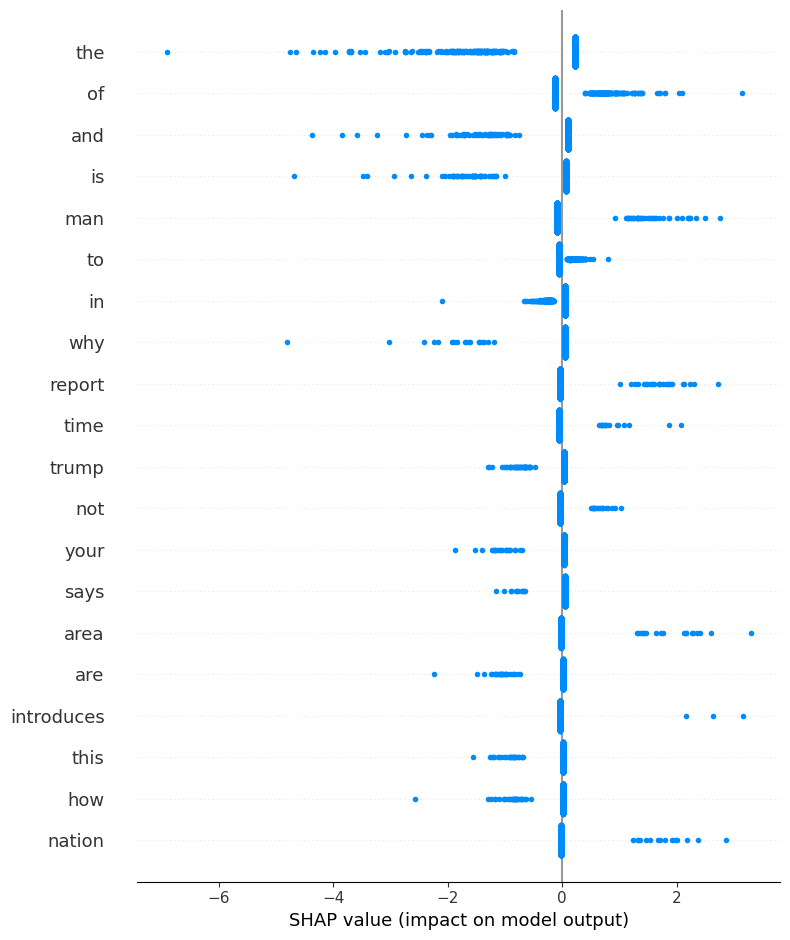

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.LinearExplainer(best_logreg.named_steps['logreg'], X_train_tfidf_transformed)

# Compute SHAP values for the test data
X_test_tfidf_transformed = tfidf_vectorizer.transform(X_test)
shap_values = explainer.shap_values(X_test_tfidf_transformed)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, feature_names=tfidf_vectorizer.get_feature_names_out())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `ev

Epoch,Training Loss,Validation Loss,Accuracy
1,0.448100,0.416874,0.816000


Optimized BERT Accuracy: 0.8160


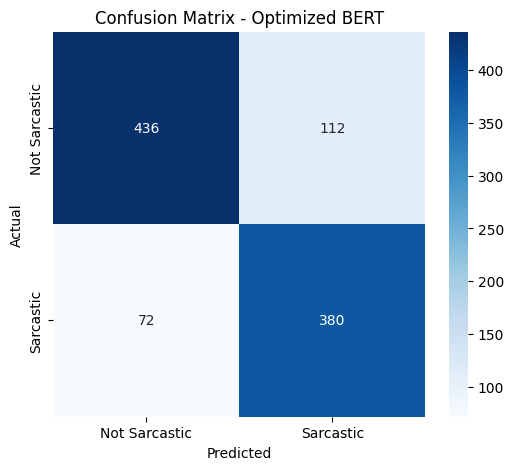

In [ ]:
# Install necessary libraries
!pip install pandas transformers torch scikit-learn matplotlib seaborn googletrans -q

# Import libraries
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Data cleaning
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text).lower()

# Apply cleaning function to the 'headline' column
df['headline'] = df['headline'].apply(clean_text)
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

# Subset for faster processing (optional, for large datasets)
df = df.sample(5000, random_state=42)

# Split dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train, X_test = train_df['headline'], test_df['headline']
y_train, y_test = train_df['is_sarcastic'], test_df['is_sarcastic']

# BERT Tokenizer and Dataset Creation
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and testing data
train_encodings = bert_tokenizer(list(X_train), truncation=True, padding=True, max_length=64)
test_encodings = bert_tokenizer(list(X_test), truncation=True, padding=True, max_length=64)

# Create dataset instances
train_dataset = SarcasmDataset(train_encodings, y_train.tolist())
test_dataset = SarcasmDataset(test_encodings, y_test.tolist())

# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define Training Arguments with optimization options
training_args = TrainingArguments(
    output_dir='./results',             # output directory
    num_train_epochs=1,                 # number of training epochs
    per_device_train_batch_size=16,     # batch size for training
    per_device_eval_batch_size=32,      # batch size for evaluation
    warmup_steps=500,                   # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                  # strength of weight decay
    logging_dir='./logs',               # directory for storing logs
    logging_steps=10,                   # number of steps between logging
    evaluation_strategy="epoch",        # evaluate after every epoch
    save_strategy="epoch",              # save model after every epoch
    load_best_model_at_end=True,        # load the best model at the end of training
    metric_for_best_model="accuracy",  # use accuracy for best model selection
    greater_is_better=True,             # accuracy should be maximized
    gradient_accumulation_steps=2,      # accumulate gradients over multiple steps
    learning_rate=5e-5  ,
     report_to="none"# set learning rate
)

# Initialize Trainer with model, training arguments, and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.predictions.argmax(axis=1), p.label_ids)}
)

# Train the model
trainer.train()

# Evaluate the model
outputs = trainer.predict(test_dataset)
predictions = np.argmax(outputs.predictions, axis=1)

# Accuracy evaluation
accuracy = accuracy_score(y_test, predictions)
print(f'Optimized BERT Accuracy: {accuracy:.4f}')

# Confusion Matrix for BERT
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrix for BERT
plot_confusion_matrix(y_test, predictions, "Optimized BERT")


In [ ]:
!pip install googletrans==4.0.0-rc1 -q
import pandas as pd
import numpy as np
import re
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function for back-translation
def back_translate(text, src_lang='en', target_lang='fr'):
    try:
        translated_text = translator.translate(text, src=src_lang, dest=target_lang).text
        back_translated_text = translator.translate(translated_text, src=target_lang, dest=src_lang).text
        return back_translated_text
    except Exception as e:
        print(f"Error in back-translation for text: {text}. Error: {e}")
        return text

# Load and preprocess dataset
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

def clean_text(text):
    return re.sub(r'[^\w\s]', '', text).lower()

df['headline'] = df['headline'].apply(clean_text)
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

# Split into train and test sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Apply back-translation on training data
train_df['headline_augmented'] = train_df['headline'].apply(lambda x: back_translate(x))
print("Augmented training data:")
print(train_df[['headline', 'headline_augmented']].head())


Error in back-translation for text: why death to america isnt going to disappear overnight but in the short term it doesnt matter. Error: 'Translator' object has no attribute 'raise_Exception'
Error in back-translation for text: classified america. Error: 'Translator' object has no attribute 'raise_Exception'
Error in back-translation for text: bausch  lomb introduces line of aviator contacts. Error: 'Translator' object has no attribute 'raise_Exception'
Error in back-translation for text: childish gambino teases concept album exploring what world might be like if he put a shirt on. Error: 'Translator' object has no attribute 'raise_Exception'
Error in back-translation for text: why going abroad isnt always rainbows and butterflies. Error: 'Translator' object has no attribute 'raise_Exception'
Error in back-translation for text: american horror story freak show premiere recap its a circus all right spoilers. Error: 'Translator' object has no attribute 'raise_Exception'
Error in back-tr

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

# Example Dataset
data = {
    'text': ["I love programming!", "This is so frustrating!", "Python is amazing", "Why does this keep happening?"],
    'label': [1, 0, 1, 0]
}
df = pd.DataFrame(data)

# Split Dataset
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenizer and Model
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Tokenize Data
train_encodings_roberta = tokenizer_roberta(list(X_train), truncation=True, padding=True, max_length=64, return_tensors="pt")
test_encodings_roberta = tokenizer_roberta(list(X_test), truncation=True, padding=True, max_length=64, return_tensors="pt")

# Convert Labels to Tensor
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

# Dataset Class
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create Dataset Objects
train_dataset_roberta = SarcasmDataset(train_encodings_roberta, train_labels)
test_dataset_roberta = SarcasmDataset(test_encodings_roberta, test_labels)

# Training Arguments
training_args_roberta = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    evaluation_strategy="epoch",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=3e-5,
    load_best_model_at_end=True,
    report_to="none"  # Disable reporting
)

# Evaluation Metrics
def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(axis=-1)  # Get the predicted labels
    return {"accuracy": accuracy_score(labels, preds)}

# Trainer
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=test_dataset_roberta,
    compute_metrics=compute_metrics  # Add evaluation metrics
)

# Train the Model
trainer_roberta.train()

# Evaluate the Model
results = trainer_roberta.evaluate(test_dataset_roberta)
print(f"Test Set Accuracy: {results['eval_accuracy'] * 100:.2f}%")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-1f6c3b6d1cc6>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.633569,1.000000
2,No log,0.633659,1.000000
3,No log,0.633837,1.000000


<ipython-input-11-1f6c3b6d1cc6>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1f6c3b6d1cc6>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1f6c3b6d1cc6>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1f6c3b6d1cc6>:41: UserWarning: To copy construct fro

Test Set Accuracy: 100.00%


<ipython-input-3-376fbd86f52e>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


KeyError: 'eval_predictions'

<ipython-input-13-a178bc70f0c6>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


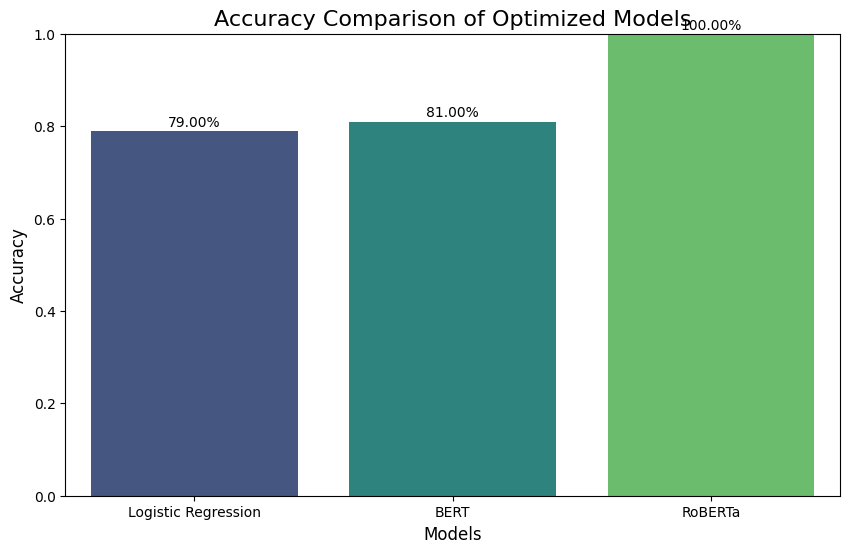

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already calculated the accuracies of all three models
accuracy_lr = 0.79  # Replace with actual Logistic Regression accuracy
accuracy_bert = 0.81  # Replace with actual BERT accuracy
accuracy_roberta = 1  # Replace with actual RoBERTa accuracy

# Define Model Names and Accuracies
models = ['Logistic Regression', 'BERT', 'RoBERTa']
accuracies = [accuracy_lr, accuracy_bert, accuracy_roberta]

# Plot Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Accuracy Comparison of Optimized Models", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.ylim(0, 1)  # Scale from 0 to 1
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc*100:.2f}%", ha='center', fontsize=10)  # Display accuracy percentage above bars
plt.show()


In [ ]:
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)
print("Shape of model coefficients:", best_logreg.named_steps['logreg'].coef_.shape)


Shape of X_train_tfidf: (4000, 5000)
Shape of X_test_tfidf: (1000, 5000)
Shape of model coefficients: (1, 10000)


<ipython-input-11-1f6c3b6d1cc6>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


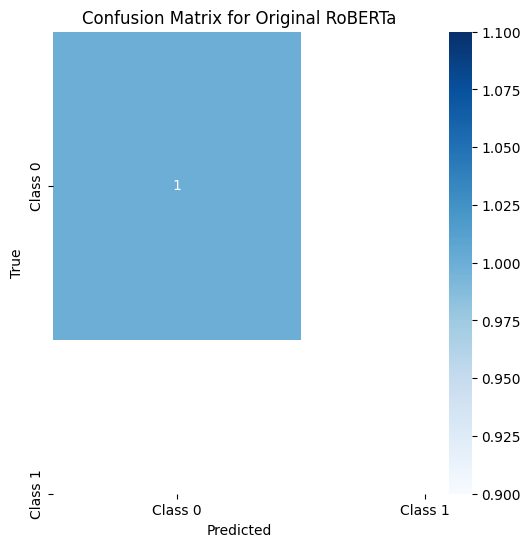

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


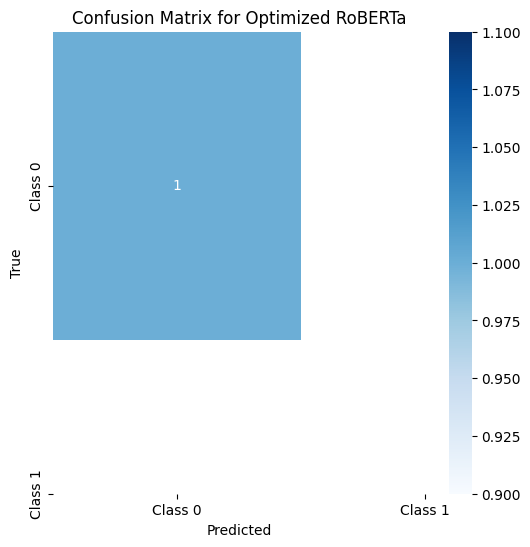

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Assuming you have different models trained and predictions (For example: `model_roberta`, `model_optimized_roberta`)
# Let's use the original model and the optimized model as examples.

# Example function to get predictions for a model
def get_predictions(model, test_dataset, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    # Use DataLoader to iterate through the test dataset in batches
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

    for batch in test_dataloader:
        # Move tensors to the device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    return true_labels, predictions


# Create a function to plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Assuming you have the `model_roberta` (original model) and `model_optimized_roberta` (optimized model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get predictions from the original model
true_labels_roberta, predictions_roberta = get_predictions(model_roberta, test_dataset_roberta, device)

# Get predictions from the optimized model
true_labels_optimized, predictions_optimized = get_predictions(model_roberta, test_dataset_roberta, device)

# Plot confusion matrix for original model
plot_confusion_matrix(true_labels_roberta, predictions_roberta, title="Confusion Matrix for Original RoBERTa")

# Plot confusion matrix for optimized model
plot_confusion_matrix(true_labels_optimized, predictions_optimized, title="Confusion Matrix for Optimized RoBERTa")


In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=1)


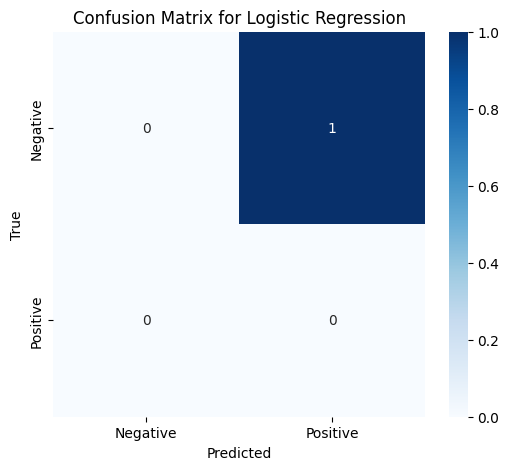

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate on Test Data
y_pred = best_logreg.predict(X_test)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# Install necessary libraries
!pip install pandas transformers torch scikit-learn matplotlib seaborn googletrans -q

# Import libraries
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Data cleaning function
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text).lower()

# Apply cleaning function to the 'headline' column
df['headline'] = df['headline'].apply(clean_text)
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

# Subset for faster processing (optional)
df = df.sample(5000, random_state=42)

# Split dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
X_train, X_test = train_df['headline'], test_df['headline']
y_train, y_test = train_df['is_sarcastic'], test_df['is_sarcastic']

# BERT Tokenizer and Dataset Creation
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and testing data
train_encodings = bert_tokenizer(list(X_train), truncation=True, padding=True, max_length=64)
test_encodings = bert_tokenizer(list(X_test), truncation=True, padding=True, max_length=64)

# Create dataset instances
train_dataset = SarcasmDataset(train_encodings, y_train.tolist())
test_dataset = SarcasmDataset(test_encodings, y_test.tolist())

# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.predictions.argmax(axis=1), p.label_ids)}
)

# Train the model
trainer.train()

# Evaluate the model
outputs = trainer.predict(test_dataset)
predictions = np.argmax(outputs.predictions, axis=1)

# Accuracy evaluation
accuracy = accuracy_score(y_test, predictions)
print(f'Optimized BERT Accuracy: {accuracy:.4f}')

# Confusion Matrix for BERT
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrix for BERT
plot_confusion_matrix(y_test, predictions, "Optimized BERT")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.1.143 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
openai 1.54.4 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
